In [2]:
# Standard library imports
import time  # For time-related functions
import copy  # For deep copy operations

# Third-party library imports
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score  # For evaluation metrics
from tqdm import tqdm  # For progress bars

# PyTorch imports
import torch  # PyTorch library for tensors and deep learning
import torch.nn as nn  # Neural network module in PyTorch
import torch.nn.functional as F  # Functions for neural networks in PyTorch
import torch.optim as optim  # Optimization algorithms in PyTorch
import torchvision  # For computer vision tasks in PyTorch
import torchvision.transforms as transforms  # For image transformations in PyTorch
from torchvision.datasets import ImageFolder  # For loading image data
from torch.utils.data import DataLoader, random_split, Dataset  # For data handling in PyTorch

# datasets library from HuggingFace
from datasets import Dataset  # Custom dataset, make sure to confirm its purpose


In [3]:
# Define a pipeline of image transformations
transform = transforms.Compose([
    # Resize the image to have a height and width of 224 pixels
    transforms.Resize((224, 224)),
    
    # Convert the image from a PIL image object to a PyTorch tensor
    transforms.ToTensor(),
    
    # NO NORMALIZATION but we could add it if we wanted to
    
])


In [4]:
# Check if GPU is available and use it, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [5]:
dataset = ImageFolder(root='../data/art-styles', transform=transform)


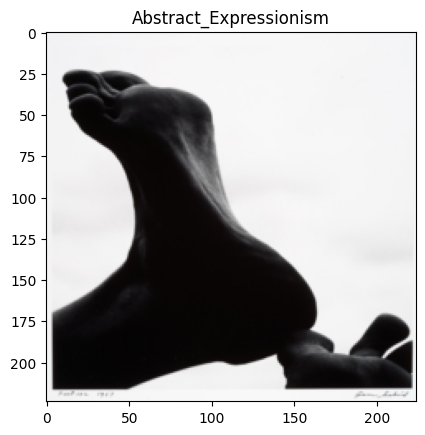

In [6]:
import matplotlib.pyplot as plt
# transpose the array to format expected by Matplotlib
array = np.transpose(dataset[0][0], (1, 2, 0))

# plot the image using Matplotlib
plt.title(dataset.classes[dataset[0][1]])
plt.imshow(array)
plt.show()


In [7]:
from collections import Counter

Counter([dataset.classes[t] for t in dataset.targets]).most_common(100)

[('Art_Nouveau_Modern', 1000),
 ('Baroque', 1000),
 ('Impressionism', 1000),
 ('Post_Impressionism', 1000),
 ('Realism', 1000),
 ('Romanticism', 1000),
 ('Symbolism', 1000),
 ('Abstract_Expressionism', 999),
 ('Expressionism', 999),
 ('Northern_Renaissance', 999)]

In [8]:
dataset

Dataset ImageFolder
    Number of datapoints: 9997
    Root location: ../data/art-styles
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [10]:
train_size, test_size

(7997, 2000)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


In [12]:
224*224*3

150528

In [13]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 224, 224])

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, input_size=None):
        super(CNN, self).__init__()
        # First convolutional layer: Takes an input with 3 channels (e.g., RGB image)
        # and outputs 16 channels with a 3x3 kernel, preserving spatial dimensions with padding
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: Reduces spatial dimensions by half (2x2 kernel with stride of 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Second convolutional layer: Takes the 16-channel output from the previous layer 
        # and outputs 32 channels, again preserving spatial dimensions with padding
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # First fully connected layer: Used for classification, connects to 512 neurons
        self.fc1 = nn.Linear(input_size, 512)
        # Second fully connected layer: Final layer that outputs to the desired number of classes
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Applying first convolutional layer followed by ReLU activation, then max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Applying second convolutional layer followed by ReLU activation, then max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the tensor for input to the fully connected layers
        x = x.view(x.size(0), -1)
        # Apply first fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Apply second fully connected layer (no activation here as it might be applied outside, e.g., Softmax for classification)
        x = self.fc2(x)
        return x

In [15]:
train_dataset

In [16]:

# Function to evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    y_true, y_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels, *extra in tqdm(test_loader, total=len(test_loader)):
            inputs = inputs.to(device)
            labels = labels.to(device)
            for e in extra:
                e = e.to(device)   
            outputs = model(inputs, *extra)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    accuracy, f1, precision, recall = evaluate_model_metrics(np.array(y_true), np.array(y_pred))
    print(f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')
    return avg_loss, accuracy, f1, precision, recall

# Function to calculate evaluation metrics
def evaluate_model_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    return accuracy, f1, precision, recall


In [17]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=5):
    model.to(device)
    since = time.time()

    test_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            dataloader = tqdm(dataloaders[phase], total=len(dataloaders[phase]))
            
            # Iterate over data.
            for inputs, labels, *extra in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                for e in extra:
                    e = e.to(device)    

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss
                    outputs = model(inputs, *extra)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Deep copy the model
            if phase == "test" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "test":
                test_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best test Acc: {best_acc:4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_acc_history


In [18]:
# learn the input size

In [27]:
num_classes = len(dataset.classes)  # Number of classes in your dataset
num_classes

10

In [20]:
# Create a sample input tensor with the size of (batch_size, channels, height, width)
sample_input = torch.randn(1, 3, 224, 224).to(device)
model = CNN(num_classes=num_classes, input_size=1)  # 1 is a dummy number
# Perform a forward pass through the convolutional layers
sample_output = model.conv1(sample_input)
sample_output = model.pool(sample_output)
sample_output = model.conv2(sample_output)
sample_output = model.pool(sample_output)

# Calculate the size of the resulting tensor
input_size = sample_output.numel()
input_size

100352

In [22]:
# 224*224*3 (150528) -CONV-> 100352 -fc1-> 512 -fc2-> 10

In [23]:
dataset.classes

['Abstract_Expressionism',
 'Art_Nouveau_Modern',
 'Baroque',
 'Expressionism',
 'Impressionism',
 'Northern_Renaissance',
 'Post_Impressionism',
 'Realism',
 'Romanticism',
 'Symbolism']

In [28]:
# Step 1: Create an instance of the CNN model
cnn_model = CNN(num_classes=num_classes, input_size=input_size)

In [29]:
cnn_model

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()

evaluate_model(cnn_model, test_loader, criterion)

100%|███████████████████████████████████████████| 32/32 [00:34<00:00,  1.09s/it]

Loss: 2.3033, Accuracy: 0.0920, F1-score: 0.0254, Precision: 0.0344, Recall: 0.0981



(2.303311549127102,
 0.092,
 0.025364766886683997,
 0.034367275892080065,
 0.09807661566395517)

In [22]:
# Step 2: Create a dictionary containing both training and validation DataLoaders
dataloaders = {"train": train_loader, "test": test_loader}

# Step 3: Define a loss function and an optimizer
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# Step 4: Train the model by calling the train_model function
num_epochs = 5
trained_cnn_model, test_acc_history = train_model(
    cnn_model, dataloaders, criterion, optimizer, device, num_epochs)


Epoch 1/5
----------


100%|█████████████████████████████████████████| 125/125 [02:14<00:00,  1.07s/it]


train Loss: 2.3078 Acc: 0.1762


100%|███████████████████████████████████████████| 32/32 [00:37<00:00,  1.18s/it]


test Loss: 2.1312 Acc: 0.1950

Epoch 2/5
----------


100%|█████████████████████████████████████████| 125/125 [02:14<00:00,  1.08s/it]


train Loss: 1.9948 Acc: 0.2744


100%|███████████████████████████████████████████| 32/32 [00:35<00:00,  1.12s/it]


test Loss: 2.0154 Acc: 0.2785

Epoch 3/5
----------


100%|█████████████████████████████████████████| 125/125 [02:09<00:00,  1.04s/it]


train Loss: 1.7356 Acc: 0.3920


100%|███████████████████████████████████████████| 32/32 [00:35<00:00,  1.11s/it]


test Loss: 1.9761 Acc: 0.3005

Epoch 4/5
----------


100%|█████████████████████████████████████████| 125/125 [02:10<00:00,  1.04s/it]


train Loss: 1.3375 Acc: 0.5441


100%|███████████████████████████████████████████| 32/32 [00:35<00:00,  1.10s/it]


test Loss: 2.2052 Acc: 0.2865

Epoch 5/5
----------


100%|█████████████████████████████████████████| 125/125 [02:10<00:00,  1.05s/it]


train Loss: 0.8649 Acc: 0.7163


100%|███████████████████████████████████████████| 32/32 [00:35<00:00,  1.11s/it]

test Loss: 2.4618 Acc: 0.2820

Training complete in 13m 60s
Best test Acc: 0.300500


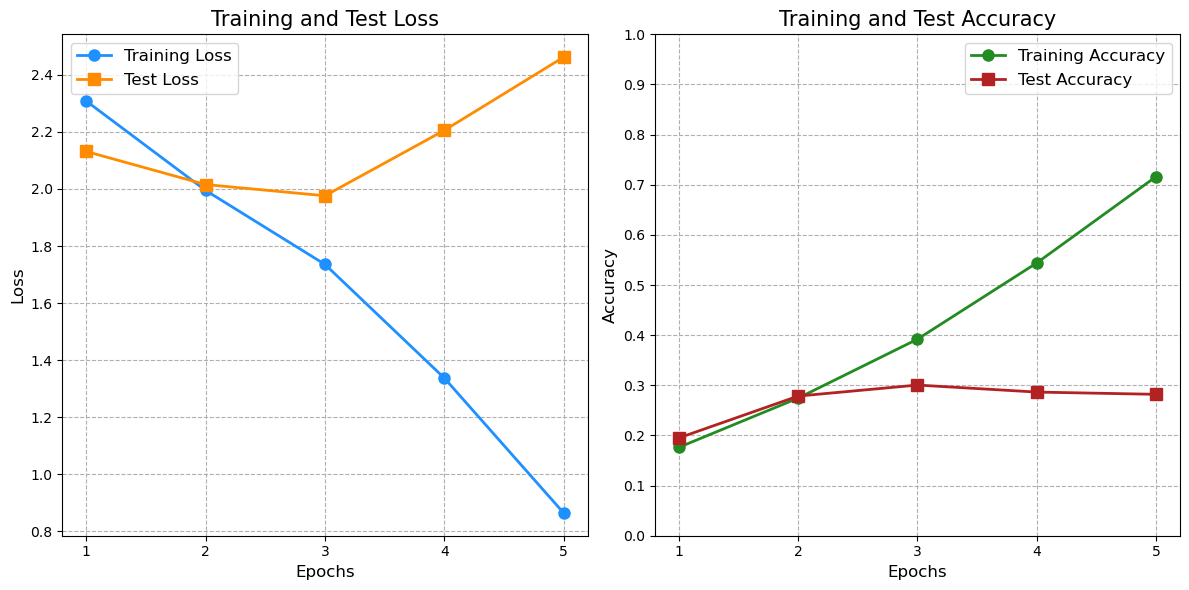

In [45]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
train_loss = [2.3078, 1.9948, 1.7356, 1.3375, 0.8649]
train_acc = [0.1762, 0.2744, 0.3920, 0.5441, 0.7163]
test_loss = [2.1312, 2.0154, 1.9761, 2.2052, 2.4618]
test_acc = [0.1950, 0.2785, 0.3005, 0.2865, 0.2820]

# Number of epochs
epochs = range(1, 6)

plt.figure(figsize=(12, 6))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', lw=2, markersize=8, label='Training Loss', color='dodgerblue')
plt.plot(epochs, test_loss, 's-', lw=2, markersize=8, label='Test Loss', color='darkorange')
plt.title('Training and Test Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--')
plt.xticks(epochs)
plt.legend(fontsize=12)

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'o-', lw=2, markersize=8, label='Training Accuracy', color='forestgreen')
plt.plot(epochs, test_acc, 's-', lw=2, markersize=8, label='Test Accuracy', color='firebrick')
plt.title('Training and Test Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--')
plt.xticks(epochs)
plt.yticks([i * 0.1 for i in range(11)]) # Y-axis in increments of 0.1
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [23]:
evaluate_model(trained_cnn_model, test_loader, criterion)  # loaded the checkpoint with the highest accuracy

100%|███████████████████████████████████████████| 32/32 [00:36<00:00,  1.13s/it]

Loss: 1.9828, Accuracy: 0.3005, F1-score: 0.2956, Precision: 0.3089, Recall: 0.3029



(1.982776328921318,
 0.3005,
 0.29556642041987574,
 0.30893504135580996,
 0.3029175038588444)

In [24]:
import torch
torch.save(trained_cnn_model.state_dict(), "../data/trained_cnn_model.pt")


The behavior we're observing, where training accuracy continually improves but test accuracy plateaus or even decreases after a certain point, is a classic sign of **overfitting**. Here's an explanation of what's happening:

1. Training Accuracy Increases: This is an indication that the model is learning and getting better at predicting the labels for the training data. As you iterate through more epochs, the model fine-tunes its parameters to minimize the error on the training set.

2. Test Accuracy Plateaus or Decreases: This suggests that while the model is getting better at predicting the training data, it's not necessarily improving its ability to generalize to new, unseen data (the test set). In other words, it's memorizing the training data rather than truly understanding underlying patterns.

Some insights into overfitting:

1. Complex Models: Overfitting is especially common in models with a large number of parameters. Such models can be highly flexible and can fit the training data very closely, including its noise and outliers. When this happens, the model starts to learn patterns that are specific to the training data and not generalizable.

2. Insufficient Training Data: Overfitting can also happen when there's not enough training data. When data is limited, the model might capture noise or random fluctuations in the training data as actual patterns.

3. Deep Learning: In the context of deep learning, without proper regularization or if trained for too many epochs, neural networks can become excellent at predicting the training data but perform poorly on new, unseen data.

To mitigate overfitting:

1. Regularization: Techniques like L1 and L2 regularization can be applied. This adds a penalty to the loss function, discouraging the model from fitting the training data too closely.

2. Dropout: In neural networks, dropout is a technique where random subsets of neurons are turned off during training. This prevents any single neuron from becoming too influential and promotes better generalization.

3. Early Stopping: Monitor the test (or validation) error while training. Stop training when the test error starts to increase, even if the training error is still decreasing.

4. Data Augmentation: This involves artificially increasing the size of the training dataset by creating modified versions of images in the dataset. This can help the model generalize better.

5. Use a simpler model: If the model has too many parameters or layers, consider using a simpler architecture.

# Text

In [25]:
# https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchtext
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

In [7]:
# Step 1: Load and preprocess the data
csv_path = '../data/disaster.csv'
df = pd.read_csv(csv_path)

In [8]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# Tokenize the text column
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
tokenized = [tokenizer(text) for text in df['text']]

# Build the vocabulary
vocab = torchtext.vocab.build_vocab_from_iterator(tokenized)

# Encode the target column
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

# Train-test split
train_data, test_data = train_test_split(df, test_size=0.2)

# Custom dataset
class TextDataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        tokens = tokenizer(text)
        encoded_text = [vocab[token] for token in tokens]
        target = self.data.iloc[idx]['target']
        return torch.tensor(encoded_text), torch.tensor(target)

In [34]:
vocab[tokenizer('a')[0]]

6

In [34]:
df['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [ ]:

# Create the dataloaders
train_dataset = TextDataset(train_data, vocab)
test_dataset = TextDataset(test_data, vocab)

from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
    # Unzips the input batch into sequences and their corresponding targets
    (sequences, targets) = zip(*batch)
    
    # Compute the lengths of each sequence in the batch. 
    # These lengths are used when packing the padded sequences before passing to an LSTM/GRU.
    lengths = torch.tensor([len(sequence) for sequence in sequences])
    
    # Pad sequences so that they have the same length, making them ready for batching.
    # 'batch_first=True' ensures the batch size is the first dimension of the output tensor.
    sequences = pad_sequence(sequences, batch_first=True)
    
    # Convert the list of targets to a tensor
    targets = torch.tensor(targets)
    
    # Return the padded sequences, their corresponding targets, and their lengths.
    return sequences, targets, lengths

train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=pad_collate)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=pad_collate)


In [27]:
# Step 2: Create the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(LSTMClassifier, self).__init__()

        # Embedding layer: Used to convert token IDs to vectors
        # Takes vocab_size as input and outputs embed_dim-sized vectors
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # LSTM layer: Takes embed_dim-sized inputs and outputs hidden_dim-sized sequences
        # batch_first=True ensures input/output tensors have batch size as the first dimension
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        # Fully connected layer: Takes hidden_dim-sized input (LSTM's output) 
        # and outputs logits for each class (num_classes)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        # Convert token IDs to vectors using embedding layer
        x = self.embedding(x)

        # Pack the sequences for LSTM. This is necessary as the sequences in a batch may have different lengths.
        # LSTM requires knowing these lengths to handle them appropriately.
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        # Forward pass through the LSTM. We only need the final hidden state (and not the entire sequence)
        # "_" is a placeholder for the output sequence which we're not using.
        _, (hidden, _) = self.lstm(x)

        # Pass the final hidden state through the fully connected layer to get the class logits
        x = self.fc(hidden.squeeze(0))

        return x


In [ ]:
vocab_size = len(vocab)
embed_dim = 64
hidden_dim = 128
num_classes = len(le.classes_)

lstm = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)


In [30]:
lstm

LSTMClassifier(
  (embedding): Embedding(23545, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [36]:
evaluate_model(lstm, test_loader, criterion)

100%|████████████████████████████████████████| 191/191 [00:00<00:00, 436.17it/s]

Loss: 0.6936, Accuracy: 0.5121, F1-score: 0.4951, Precision: 0.4951, Recall: 0.4952



(0.693604115104176,
 0.5121470781352594,
 0.49508082756503535,
 0.49513749883414765,
 0.49518345852906276)

In [37]:
# Create a dictionary containing both training and validation DataLoaders
dataloaders = {"train": train_loader, "test": test_loader}

# Train the model by calling the train_model function
num_epochs = 5
trained_lstm_model, test_acc_history = train_model(lstm, dataloaders, criterion, optimizer, device, num_epochs)


Epoch 1/5
----------


100%|█████████████████████████████████████████| 762/762 [00:09<00:00, 79.92it/s]


train Loss: 0.6161 Acc: 0.6658


100%|████████████████████████████████████████| 191/191 [00:00<00:00, 433.36it/s]


test Loss: 0.5666 Acc: 0.7275

Epoch 2/5
----------


100%|█████████████████████████████████████████| 762/762 [00:09<00:00, 78.37it/s]


train Loss: 0.4902 Acc: 0.7803


100%|████████████████████████████████████████| 191/191 [00:00<00:00, 439.48it/s]


test Loss: 0.5463 Acc: 0.7466

Epoch 3/5
----------


100%|█████████████████████████████████████████| 762/762 [00:09<00:00, 76.65it/s]


train Loss: 0.3664 Acc: 0.8496


100%|████████████████████████████████████████| 191/191 [00:00<00:00, 431.95it/s]


test Loss: 0.5738 Acc: 0.7505

Epoch 4/5
----------


100%|█████████████████████████████████████████| 762/762 [00:10<00:00, 74.78it/s]


train Loss: 0.2465 Acc: 0.9056


100%|████████████████████████████████████████| 191/191 [00:00<00:00, 414.06it/s]


test Loss: 0.6847 Acc: 0.7374

Epoch 5/5
----------


100%|█████████████████████████████████████████| 762/762 [00:10<00:00, 73.49it/s]


train Loss: 0.1534 Acc: 0.9432


100%|████████████████████████████████████████| 191/191 [00:00<00:00, 419.02it/s]

test Loss: 0.8100 Acc: 0.7275

Training complete in 0m 52s
Best test Acc: 0.750492


In [38]:
evaluate_model(trained_lstm_model, test_loader, criterion)

100%|████████████████████████████████████████| 191/191 [00:00<00:00, 436.84it/s]

Loss: 0.5750, Accuracy: 0.7505, F1-score: 0.7378, Precision: 0.7452, Recall: 0.7344



(0.5749956137300786,
 0.7504924491135916,
 0.7378068449112583,
 0.7451622675453758,
 0.7343644510457457)

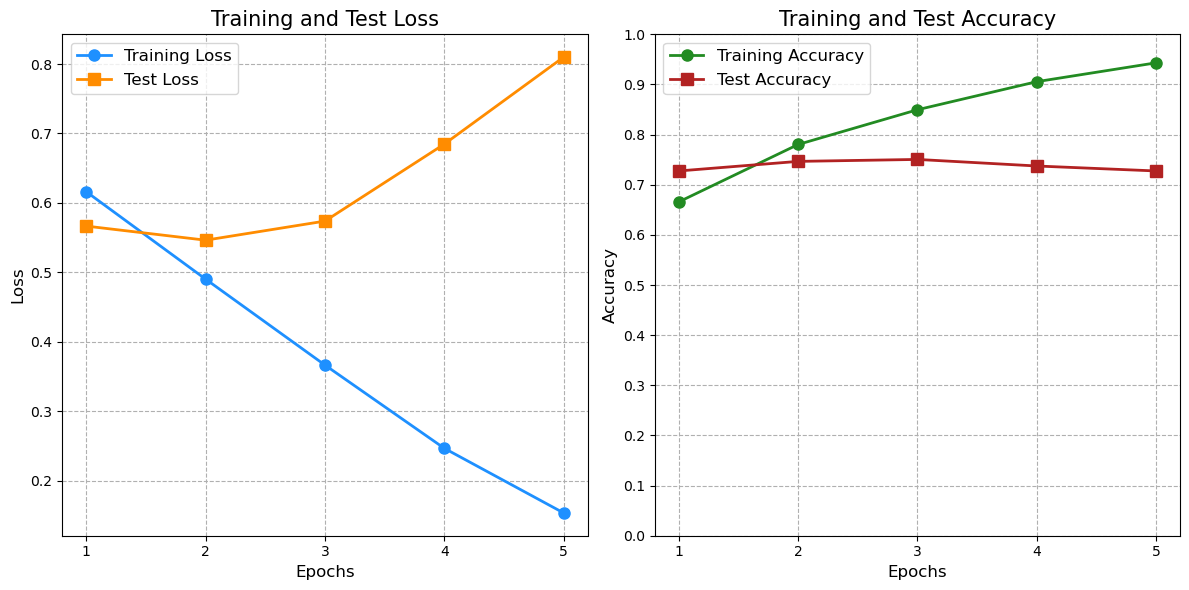

In [42]:
import matplotlib.pyplot as plt

# Loss values for each epoch
train_loss = [0.6161, 0.4902, 0.3664, 0.2465, 0.1534]
test_loss = [0.5666, 0.5463, 0.5738, 0.6847, 0.8100]

# Accuracy values for each epoch
train_acc = [0.6658, 0.7803, 0.8496, 0.9056, 0.9432]
test_acc = [0.7275, 0.7466, 0.7505, 0.7374, 0.7275]

# Number of epochs
epochs = range(1, 6)

plt.figure(figsize=(12, 6))

# Plot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', lw=2, markersize=8, label='Training Loss', color='dodgerblue')
plt.plot(epochs, test_loss, 's-', lw=2, markersize=8, label='Test Loss', color='darkorange')
plt.title('Training and Test Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--')
plt.xticks(epochs)
plt.legend(fontsize=12)

# Plot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'o-', lw=2, markersize=8, label='Training Accuracy', color='forestgreen')
plt.plot(epochs, test_acc, 's-', lw=2, markersize=8, label='Test Accuracy', color='firebrick')
plt.title('Training and Test Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--')
plt.xticks(epochs)
plt.yticks([i * 0.1 for i in range(11)]) # Y-axis in increments of 0.1
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()
